In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

In [180]:
df = pd.read_csv("adult_dataset.csv")

print("Initial Shape:", df.shape)
df.head()

Initial Shape: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40.0,NaN,<=50K
1,50.0,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K


2. Data Preprocessing

In [181]:
df.replace("?", np.nan, inplace=True)

# Convert object → category (memory efficient)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

# Numerical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include="category").columns

# Fill missing values
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

Outlier Detection & Treatment (IQR Method)

In [182]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, upper)
    return df

for col in num_cols:
    if col != "income":
        df = cap_outliers(df, col)

In [183]:
df_clustering = df.drop("income", axis=1)

In [184]:
num_cols = df_clustering.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df_clustering.select_dtypes(include="category").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", sparse_output=True), cat_cols)
    ]
)

X = preprocessor.fit_transform(df_clustering)
X = X.astype(np.float32)

print("Shape after encoding:", X.shape)

Shape after encoding: (48842, 97)


4.1 Age Distribution

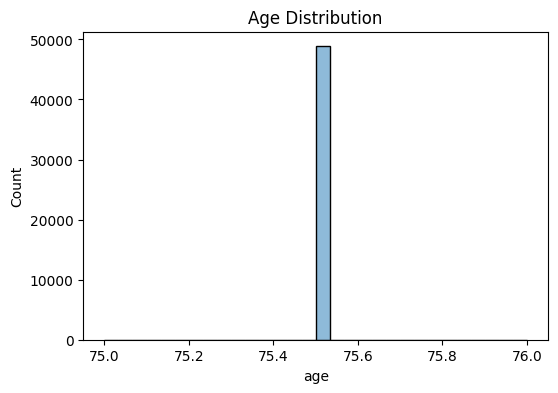

In [185]:
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

4.2 Hours per Week

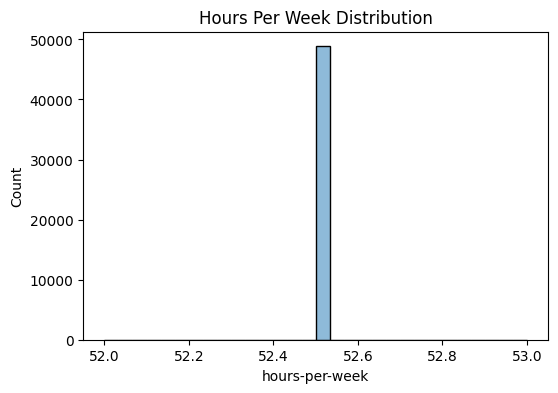

In [186]:
plt.figure(figsize=(6,4))
sns.histplot(df['hours-per-week'], bins=30, kde=True)
plt.title("Hours Per Week Distribution")
plt.show()

4.3 Education Level

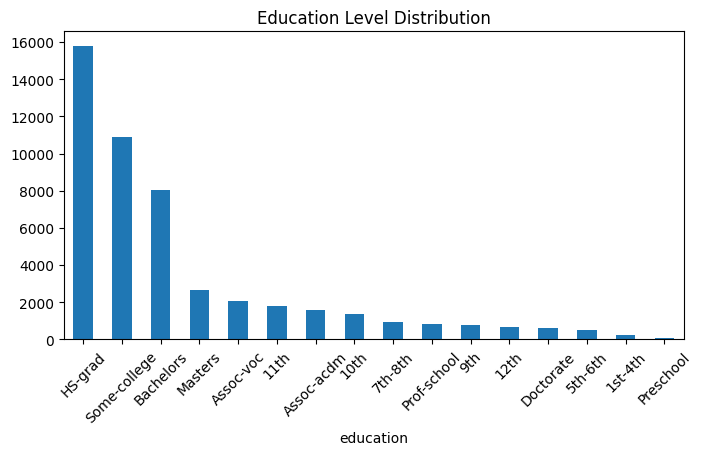

In [187]:
plt.figure(figsize=(8,4))
df['education'].value_counts().plot(kind='bar')
plt.title("Education Level Distribution")
plt.xticks(rotation=45)
plt.show()

4.4 Skewness Analysis

In [188]:
print("Skewness:")
print("Capital Gain:", df['capital-gain'].skew())
print("Capital Loss:", df['capital-loss'].skew())

Skewness:
Capital Gain: 0.0
Capital Loss: 0.0


4.5 Correlation Matrix

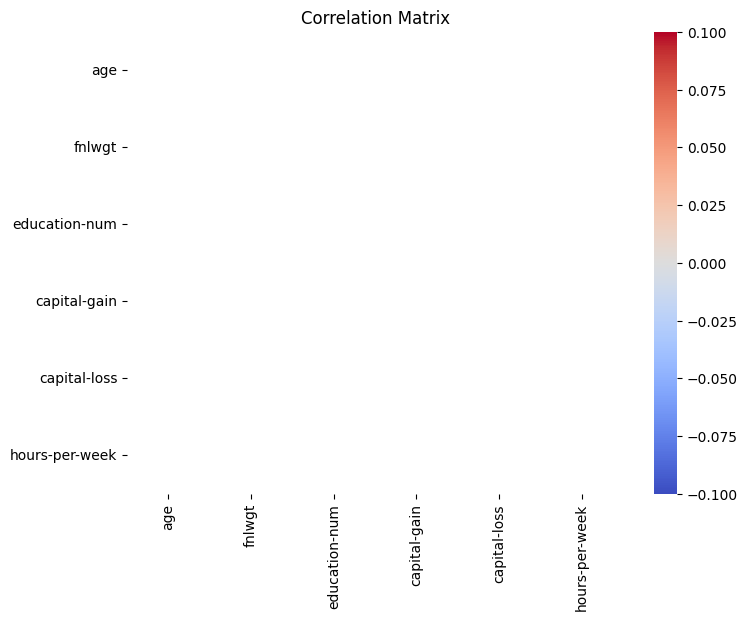

In [189]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

5.1 Elbow Method

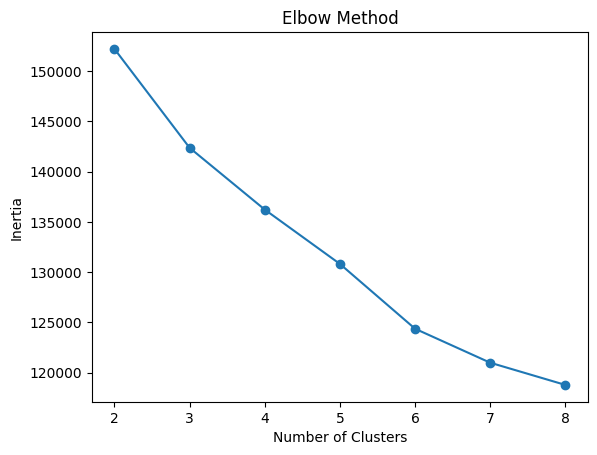

In [190]:
inertia = []
K = range(2, 9)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

5.2 Silhouette Score & Final Model (Example K=4)

In [191]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

print("Silhouette Score (KMeans):",
      silhouette_score(X, kmeans_labels))

Silhouette Score (KMeans): 0.09279619


6.1 Dendrogram (Sample for Speed)

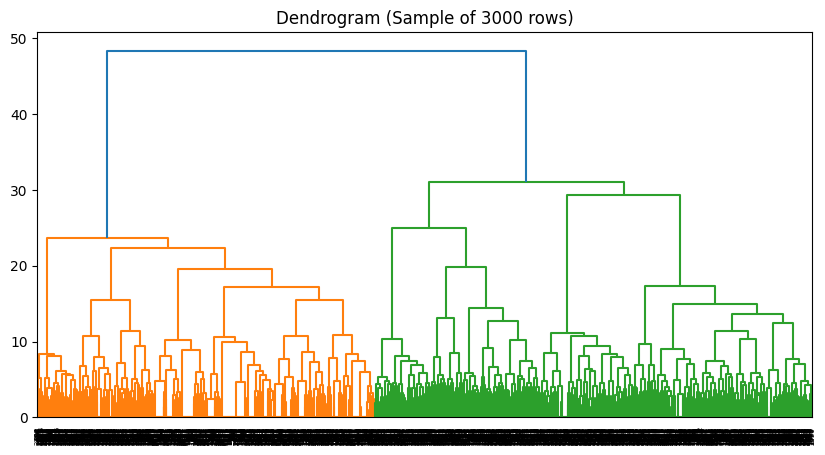

In [192]:
# Take small sample
sample_size = 3000
sample = X[:sample_size]

# Convert sparse → dense (ONLY sample!)
sample_dense = sample.toarray()

# Generate linkage matrix
linked = linkage(sample_dense, method='ward')

plt.figure(figsize=(10,5))
dendrogram(linked)
plt.title("Dendrogram (Sample of 3000 rows)")
plt.show()

6.2 Apply Agglomerative

In [193]:
pca_reduction = PCA(n_components=20)
X_reduced = pca_reduction.fit_transform(X)

In [194]:
sample = X_reduced[:3000]

agg = AgglomerativeClustering(n_clusters=4)
agg_labels = agg.fit_predict(sample)

print("Silhouette Score (Agglomerative):",
      silhouette_score(sample, agg_labels))

Silhouette Score (Agglomerative): 0.14742367


PCA FOR VISUALIZATION

In [195]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained Variance Ratio:",
      pca.explained_variance_ratio_)
print("Total Variance:",
      sum(pca.explained_variance_ratio_))

Explained Variance Ratio: [0.1495988  0.08280645]
Total Variance: 0.23240526


7.1 PCA – KMeans

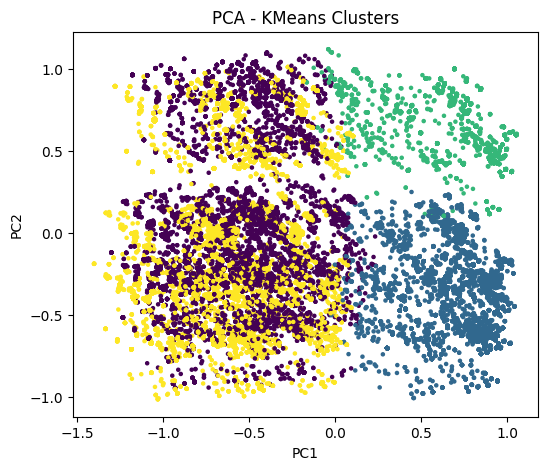

In [196]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=kmeans_labels,
            s=5)
plt.title("PCA - KMeans Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The low silhouette scores show that workforce groups overlap and are not clearly separated. Agglomerative clustering performed better than K-Means, which suggests the workforce may have a layered or hierarchical structure. Since PCA captures only 23% of the total variance in two components, the data is highly complex and cannot be fully represented in just two dimensions. Therefore, workforce policies should be flexible and gradual rather than based on strict group divisions.